This file is about extracting and splicing spectra which is observed by BFOSC E9+G10. The packages can be downloaded in the following webs:

- [extract code](https://github.com/hypergravity/bfosc)
- [splice code](https://github.com/lidihei/pyrafspec)

# first 
- extract the spectra from 2D spctra image

- $ cd /E9G10/gui

- $ python main.py

# second
- splice spectra

In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from astropy.io import fits
import numpy as np
from pyrafspec.fitslist import *
import matplotlib.pyplot as plt
from pyrafspec import splicing_spectrum
from pyrafspec.bfosclog import *
import pyrafspec.bfosce9g10 as bfosce9g10
import os
from astropy.time import Time
from astropy import constants, units
from PyAstronomy import pyasl
from astropy import coordinates as coord
from pyrafspec.spec_tools import rvcorr_spec
from laspec import normalization as lanorm
import joblib
import collections
from astropy.table import Table
plt.style.use('lijiaostyle')



In [5]:
# raw data directory
dire = '/home/lcq/media/backup/216BFOSC/20211113_bfosc/'

# log file
logfile = os.path.join(dire, '20211113_New.log')

- list the star file and their conrresponding lamp file

# and star and list by observation log

In [6]:
###-------- the data observed after 20211023
fout = os.path.join(dire, 'starlamplist.csv')
starlist, lamplist = match_star2lamp(logfile, equipment='G10_E9', lamp_expt= 300, fout=fout)

###-------- the data observed before 20211023
#starlist, lamplist = match_star2lamp_2020(logfile, equipment='G10_E9', lamp_expt= 300, fout=fout)

In [7]:
pwd

'/home/lcq/Documents/bfosc_new/bfosc-main/tutorial'

In [8]:
assert lamplist.shape == starlist.shape

# compare splicing spectrum with the normlize spectrum of single order

202111130027_SPECSLAMP_FeAr_slit16s_G10_E9 202111130025_SPECSTARGET_J21033245+3035378_slit16s_G10_E9


(4000.0, 4500.0)

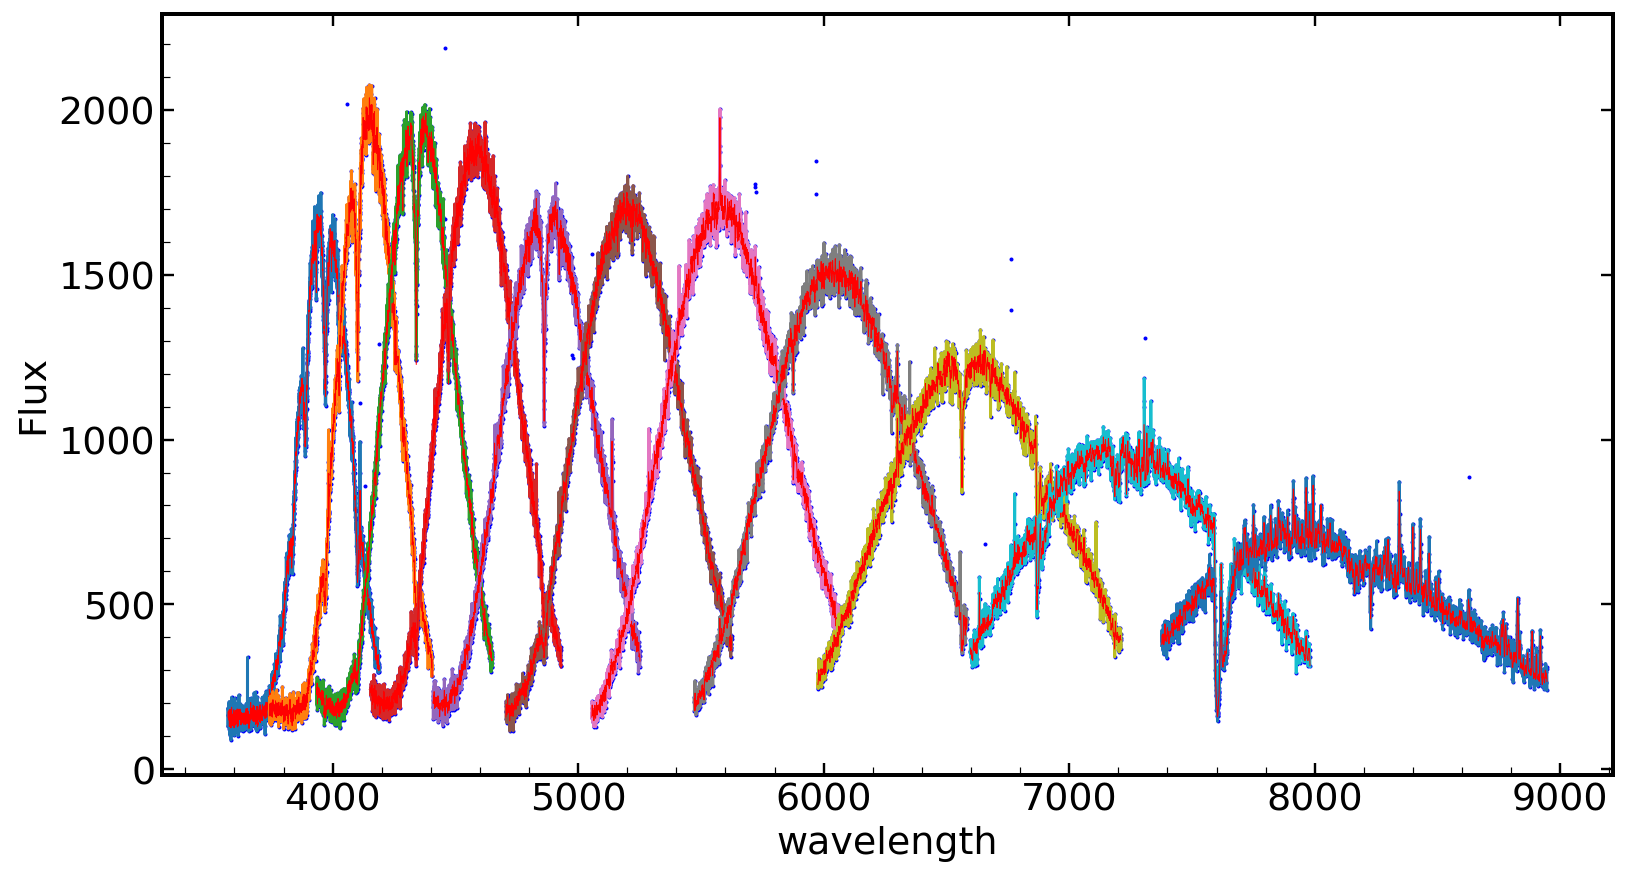

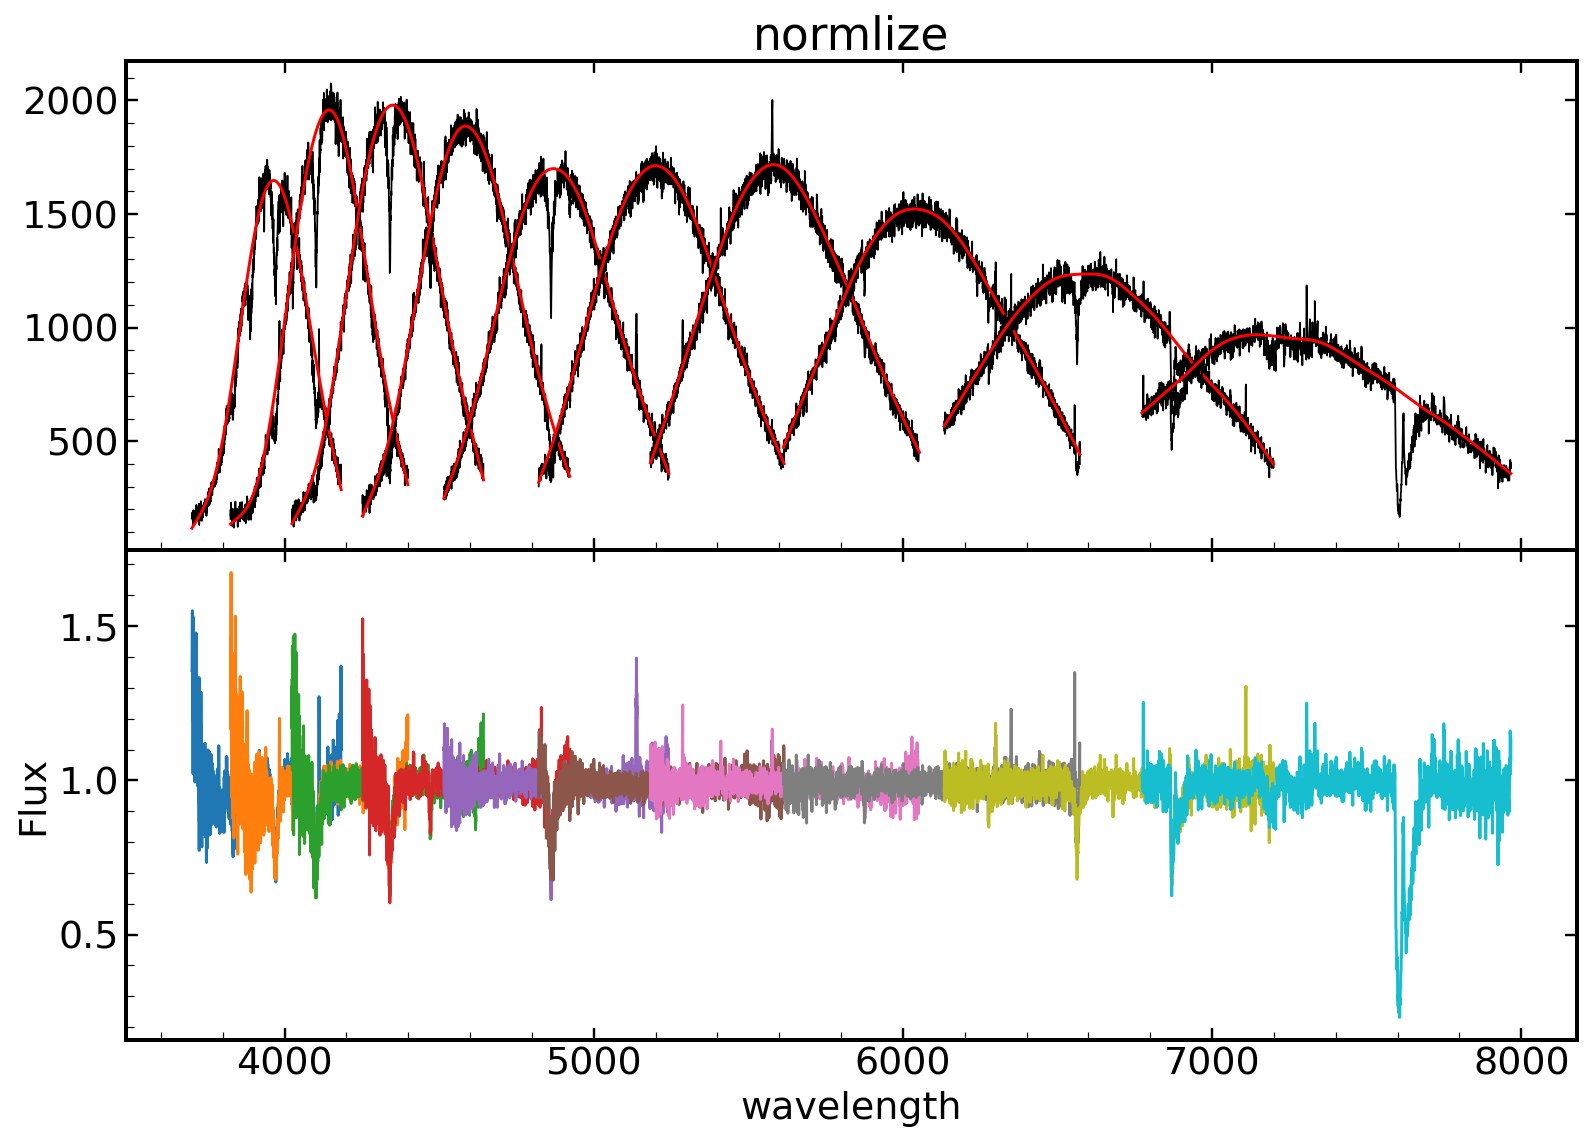

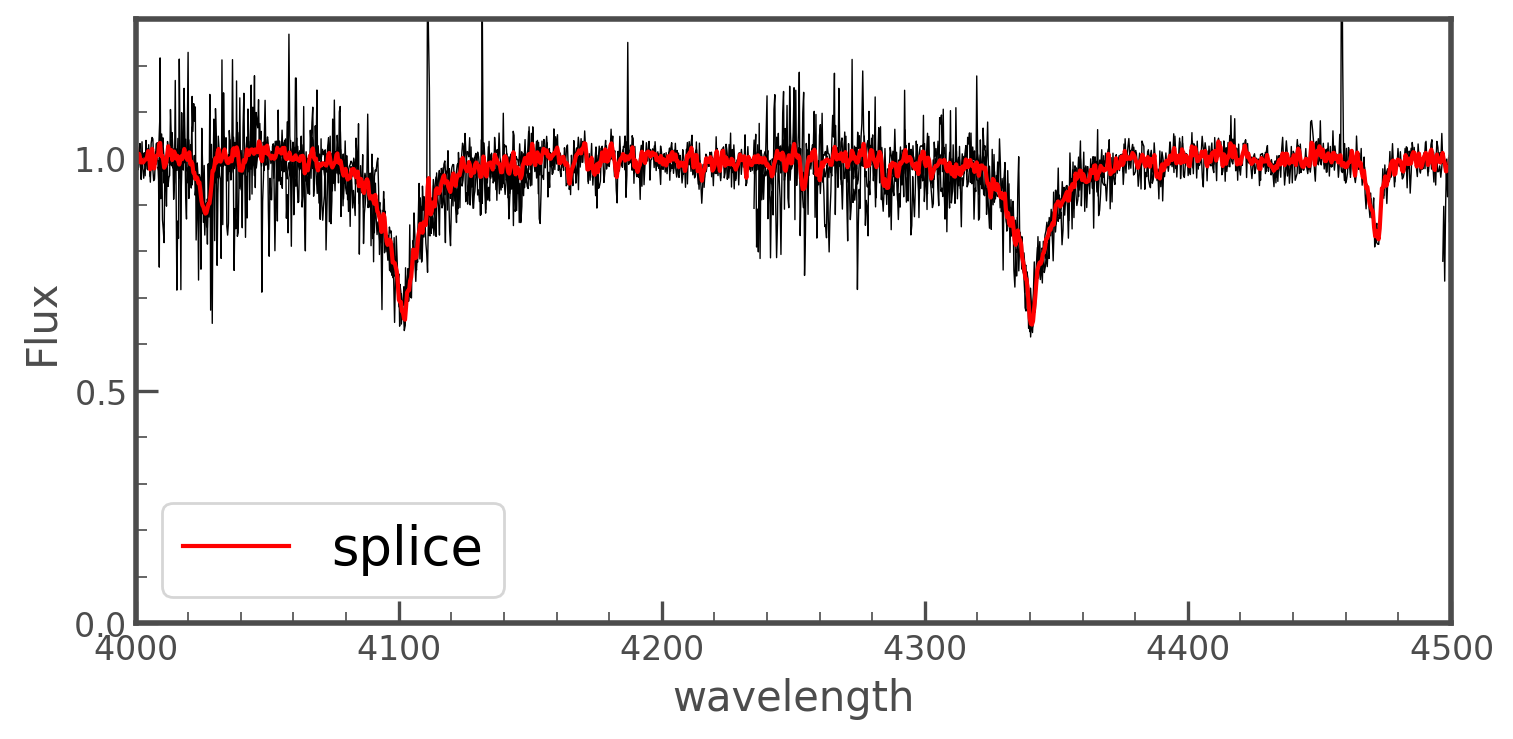

In [22]:
def funcnorm(wave, flux, show=False):
    flux_norm, flux_smoothed =lanorm.normalize_spectrum_spline(wave, flux, p=1E-6, q=0.5, lu=(-1, 3), binwidth=150, niter=5)
    if show:
       plt.plot(wave, flux)
       plt.plot(wave, flux_smoothed)
    return flux_norm, flux_smoothed

fig, ax = plt.subplots(1,1, figsize=[13,7])
#fig2, ax2 = plt.subplots(1,1, figsize=[13,7])
for _i, flamp in enumerate(lamplist[2:3]):
    fstar = starlist[2:3][_i]
    print(flamp, fstar)
    fwave, fflux, starfit, lampfit = bfosce9g10.dumpname(flamp, fstar, dire)
    star = splicing_spectrum.combine_wave_flux(fwave, fflux)
    waves = star['wavelength']['wave_solu']
    fluxs = star['flux']['spec_extr']
    flux_errs = star['flux']['err_extr']
    blaze = star['flux']['blaze']
    logwave, flux, flux_err = splicing_spectrum.splicing_spectrum(fwave, fflux, R=3500, N=3, lam_start=3700, lam_end=8900, 
                                                                  pix=[300, 2030], orders=np.arange(0, 10), funcnorm=funcnorm, 
                                                                   divide_blaze=False, threshold_blaze=700,
                                                                  show=True, ax=ax)
    for _i, wave in enumerate(waves):
        flux_norm, flux_smoothed = funcnorm(wave, fluxs[_i])
        plt.plot(wave[250:1950], flux_norm[250:1950], 'k', lw=0.5)

    
#fig, ax = plt.subplots(1,1, figsize=[13,7])
plt.plot(10**logwave, flux, color='r', label='splice')
plt.legend()
plt.xlim(4000, 4500)
#plt.xlim(6500, 6600)

# $f_{splice} = \frac{\sum{f^{i}}}{\sum{f^{i}_{c}}}$

- page 28 of specnan2014

# $\frac{flux}{blaze}$

202111130027_SPECSLAMP_FeAr_slit16s_G10_E9 202111130025_SPECSTARGET_J21033245+3035378_slit16s_G10_E9


No handles with labels found to put in legend.


(4000.0, 4500.0)

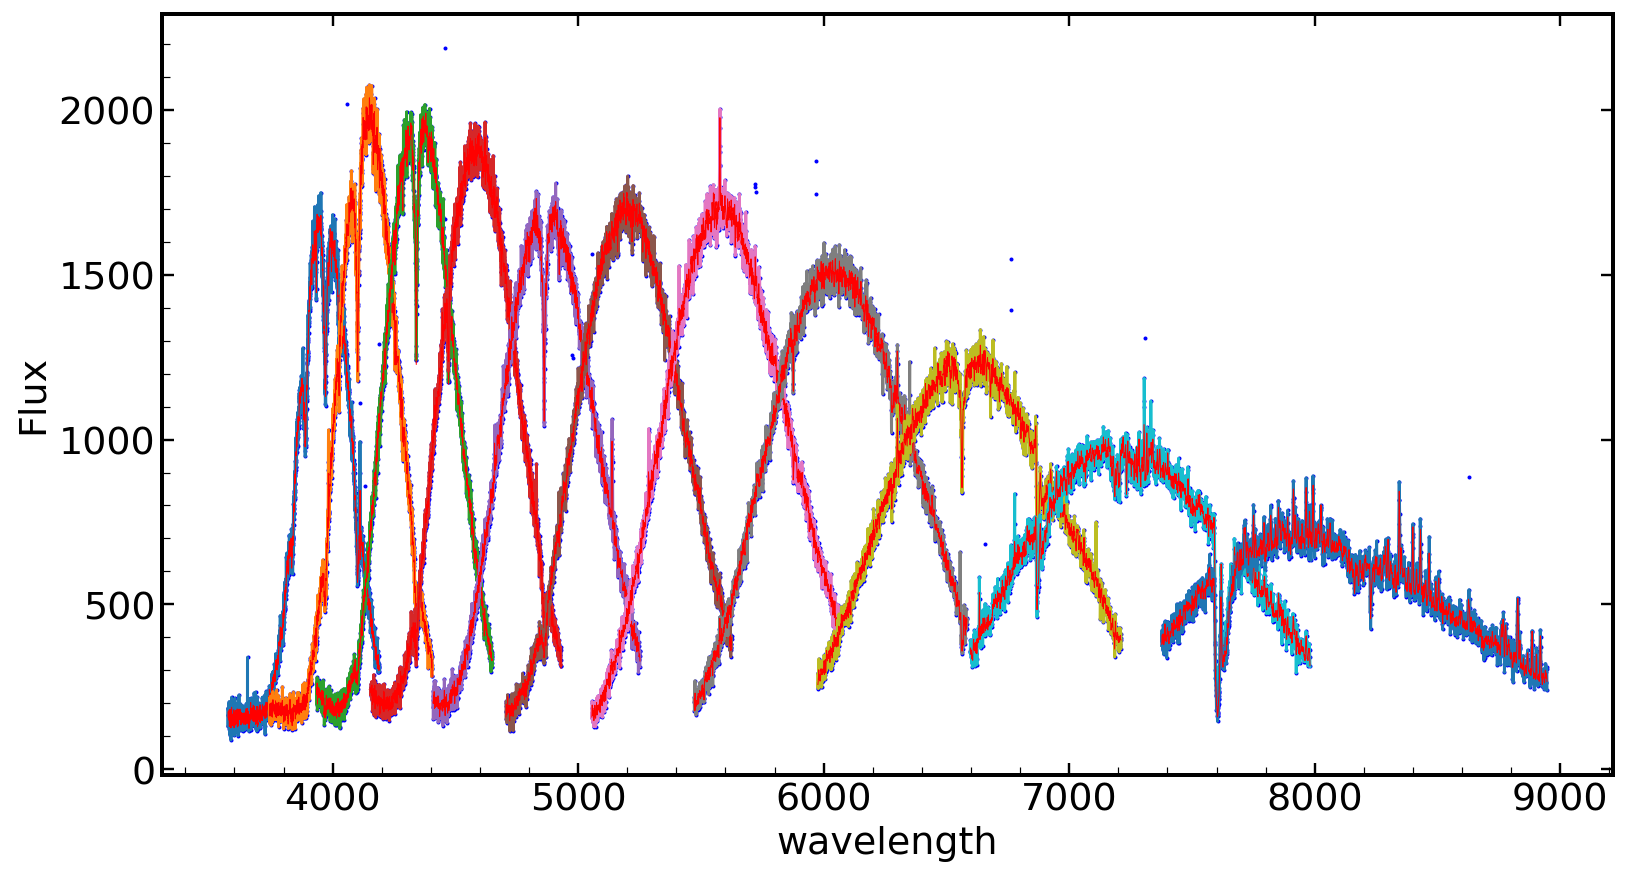

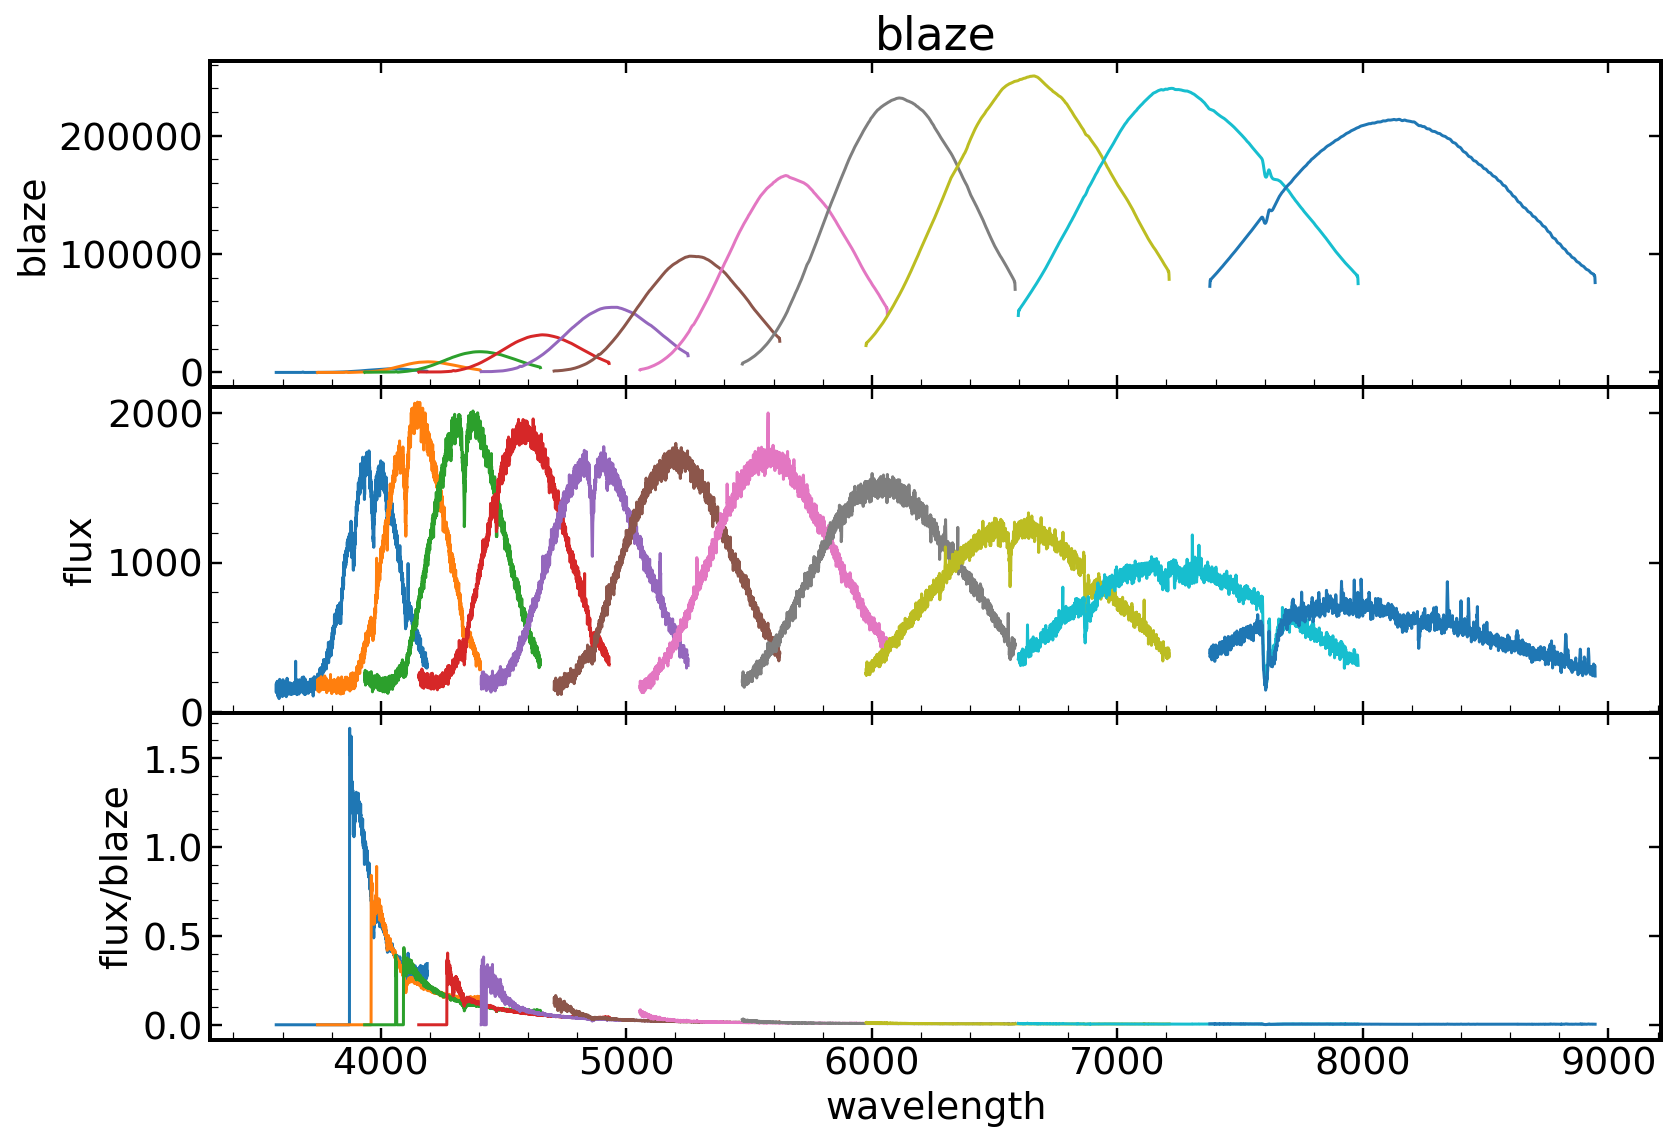

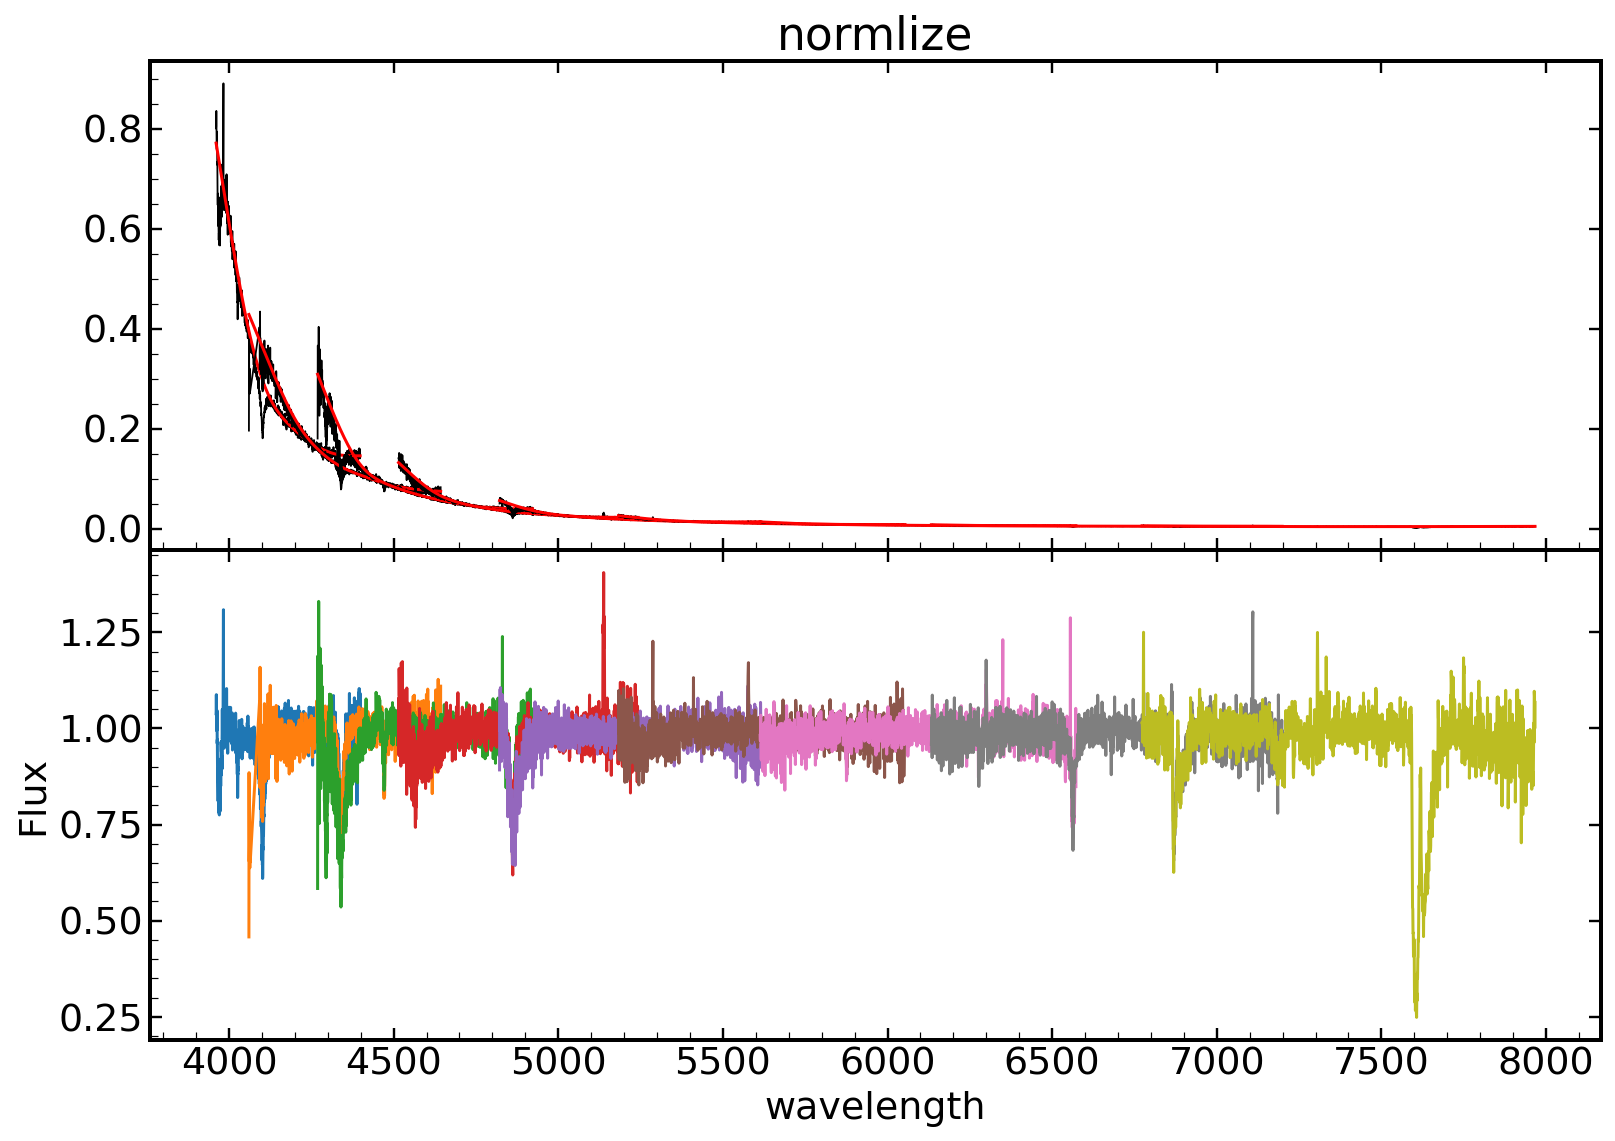

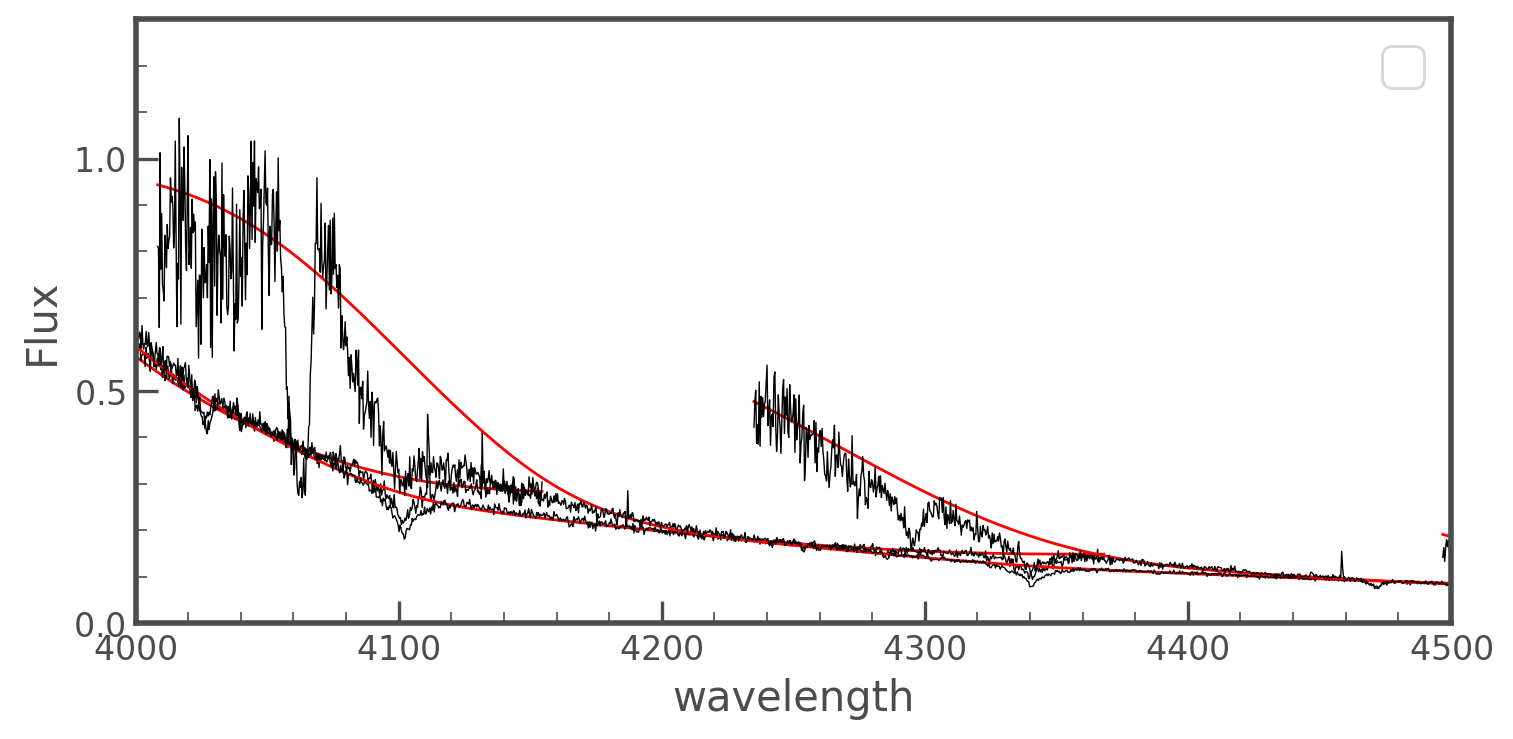

In [39]:
fig, ax = plt.subplots(1,1, figsize=[13,7])
#fig2, ax2 = plt.subplots(1,1, figsize=[13,7])
for _i, flamp in enumerate(lamplist[2:3]):
    fstar = starlist[2:3][_i]
    print(flamp, fstar)
    fwave, fflux, starfit, lampfit = bfosce9g10.dumpname(flamp, fstar, dire)
    star = splicing_spectrum.combine_wave_flux(fwave, fflux)
    waves = star['wavelength']['wave_solu']
    fluxs = star['flux']['spec_extr']
    blaze = star['flux']['blaze']
    flux_errs = star['flux']['err_extr']
    logwave, flux, flux_err = splicing_spectrum.splicing_spectrum(fwave, fflux, R=3500, N=3, lam_start=3700, lam_end=8900, 
                                                                  pix=[300, 2030], orders=np.arange(1, 10), funcnorm=funcnorm, 
                                                                   divide_blaze=True, threshold_blaze=700,
                                                                  show=True, ax=ax)
    for _i, wave in enumerate(waves):
        flux_norm, flux_smoothed = funcnorm(wave, fluxs[_i]/blaze[_i])
        #plt.plot(wave[250:1950], flux_norm[250:1950], 'k', lw=0.5)
        plt.plot(wave[250:1950], flux_smoothed[250:1950], 'r', lw=1)
        plt.plot(wave[250:1950], fluxs[_i][250:1950]/blaze[_i][250:1950], 'k', lw=0.5)

    
#fig, ax = plt.subplots(1,1, figsize=[13,7])
#plt.plot(10**logwave, flux, color='r', label='splice')
plt.legend()
plt.xlim(4000, 4500)
#plt.xlim(6500, 6600)

In [60]:
fitslists = []
for _i, flamp in enumerate(lamplist):
    fstar = starlist[_i]
    print(flamp, fstar)
    fwave, fflux, starfit, lampfit = bfosce9g10.dumpname(flamp, fstar, dire)
    star = splicing_spectrum.combine_wave_flux(fwave, fflux)
    logwave, flux, flux_err = splicing_spectrum.splicing_spectrum(fwave, fflux, R=3000, N=3, lam_start=3700, 
                                                                          lam_end=8900, pix=[200, 2030], orders=np.arange(0, 11), 
                                                                          funcnorm=funcnorm, divide_blaze=False, threshold_blaze=100, ax=ax,
                                                                          sigma =8, percentile_up=99, window_length=11, show=False)
                                                                          
    table = fits.BinTableHDU.from_columns([
                    fits.Column(name='loglambda',  format='E', array=np.array(logwave, dtype=np.float32)),
                    fits.Column(name='flux',format='E', array=np.array(flux, dtype=np.float32)),
                    fits.Column(name='error',format='E', array=np.array(flux_err, dtype=np.float32))
                                         ])
    header = fits.getheader(starfit)
    data0 = np.zeros(1,dtype=np.float32)
    hdu = fits.PrimaryHDU(data0)
    hdu.header = header
    hdu.header['fstar'] = (fstar, 'fname of star raw image')
    hdu.header['flamp'] = (flamp, 'fname of lamp raw image')
    ##########################################################################################
    jd = header['JD'] + header['EXPOSURE']/2./3600./24.
    ##--------------light_travel_time----------------------------------------------------------
    ##radec is the coordinates of the objects e.g. '04:11:10.73 +50:42:29.60'
    radec = f"{header['RA']} {header['DEC']}"
    ip_peg = coord.SkyCoord(radec, unit=(units.hourangle, units.deg), frame='icrs')
    site = coord.EarthLocation.of_site('Beijing Xinglong Observatory')
    times_ltt = Time(jd, format='jd', scale='utc', location=site)
    ltt = times_ltt.light_travel_time(ip_peg,'barycentric')
    barycorr = ip_peg.radial_velocity_correction(obstime=Time(times_ltt.iso), location=site)
    #----------------------------------------------------------------------------------------
    header['BJD'] = (jd+ltt.jd, 'Barycentric Julian Date at mean of exposure')
    header['barycorr'] = (barycorr.to('km/s').value, 'km/s(barycentric rv=rv+barycorr+rv*barycorr/c)')
    ###########################################################################################
    hdul = fits.HDUList([hdu, table])
    fout = starfit[:-4] +'_splicing.fits'
    hdul.writeto(fout, overwrite=True)
    fitslists.append(fout)

202111130022_SPECSLAMP_FeAr_slit16s_G10_E9 202111130021_SPECSTARGET_BD+25d4655_slit16s_G10_E9
202111130027_SPECSLAMP_FeAr_slit16s_G10_E9 202111130024_SPECSTARGET_J21033245+3035378_slit16s_G10_E9
202111130027_SPECSLAMP_FeAr_slit16s_G10_E9 202111130025_SPECSTARGET_J21033245+3035378_slit16s_G10_E9
202111130027_SPECSLAMP_FeAr_slit16s_G10_E9 202111130026_SPECSTARGET_J21033245+3035378_slit16s_G10_E9
202111130032_SPECSLAMP_FeAr_slit16s_G10_E9 202111130029_SPECSTARGET_J22373662+2244135_slit16s_G10_E9
202111130032_SPECSLAMP_FeAr_slit16s_G10_E9 202111130030_SPECSTARGET_J22373662+2244135_slit16s_G10_E9
202111130032_SPECSLAMP_FeAr_slit16s_G10_E9 202111130031_SPECSTARGET_J22373662+2244135_slit16s_G10_E9
202111130037_SPECSLAMP_FeAr_slit16s_G10_E9 202111130034_SPECSTARGET_J22555818+343117_slit16s_G10_E9
202111130037_SPECSLAMP_FeAr_slit16s_G10_E9 202111130035_SPECSTARGET_J22555818+343117_slit16s_G10_E9
202111130037_SPECSLAMP_FeAr_slit16s_G10_E9 202111130036_SPECSTARGET_J22555818+343117_slit16s_G10_E9


# check the spectra of the day

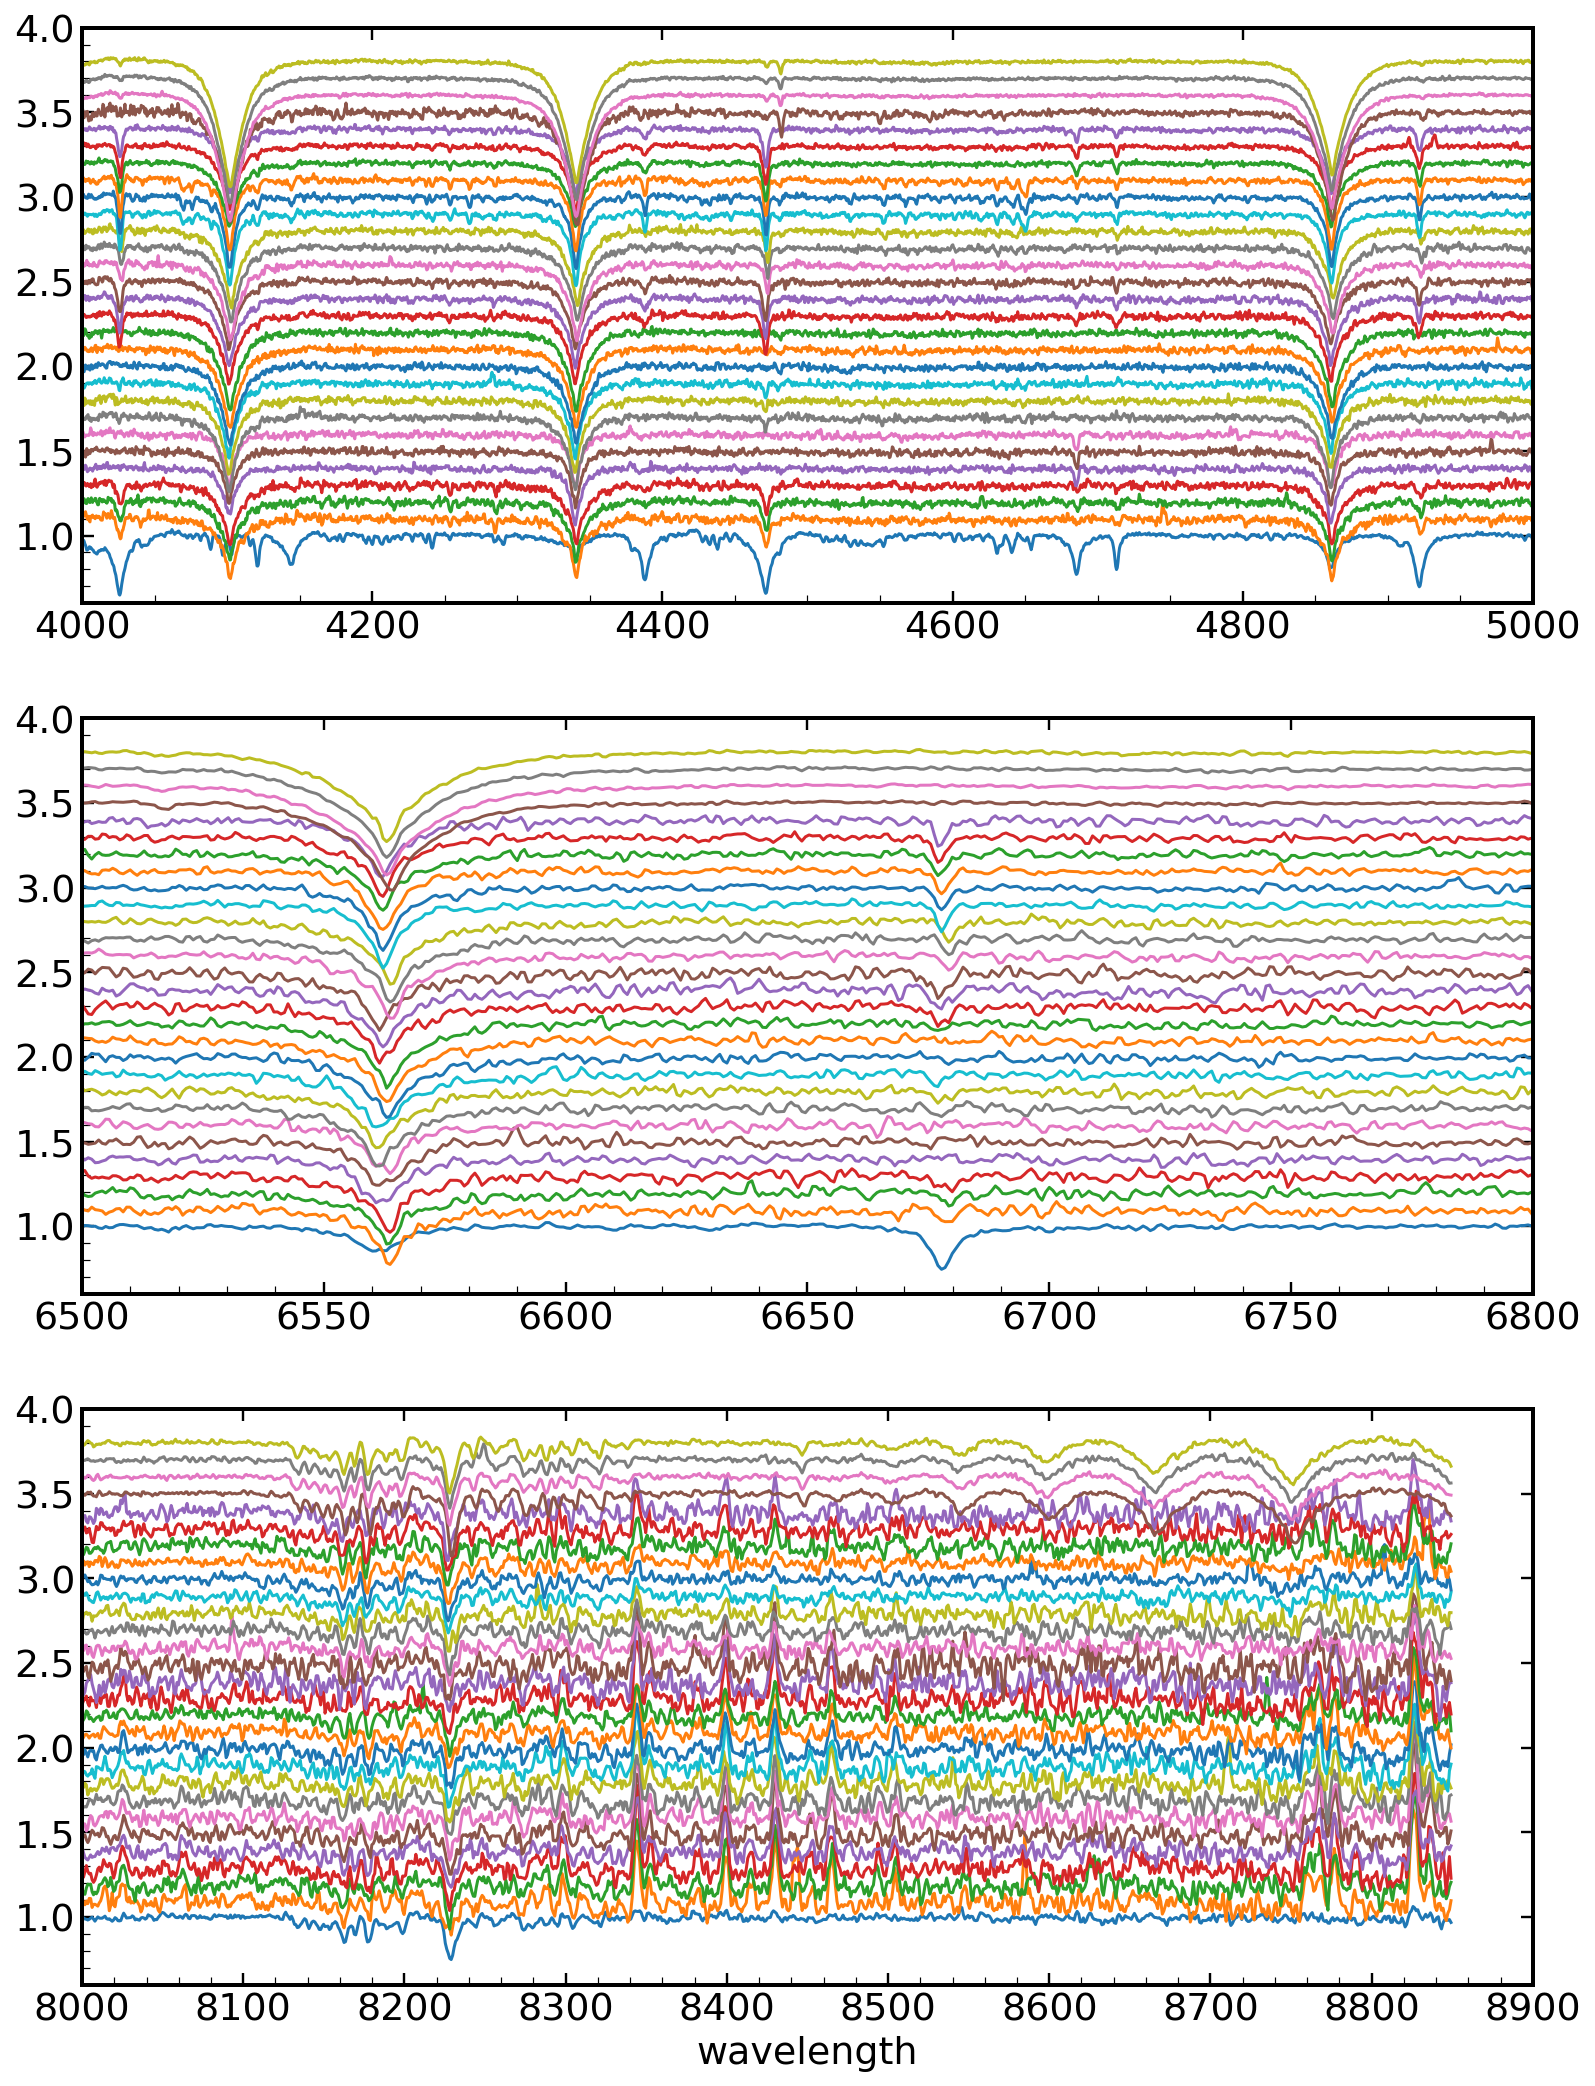

In [45]:
fig, axs = plt.subplots(3,1, figsize=[13,18])
plt.sca(axs[0])
plt.xlim([4000, 5000])
plt.ylim([0.6, 4])
plt.sca(axs[1])
plt.xlim([6500, 6800])
plt.ylim([0.6, 4])
plt.sca(axs[2])
plt.xlim([8000, 8900])
plt.ylim([0.6, 4])
plt.xlabel('wavelength')
for _i, fname in enumerate(fitslists):
    data = fits.getdata(fname, 1)
    wave = 10**data['loglambda']
    flux = data['flux']
    plt.sca(axs[0])
    plt.plot(wave, flux+_i*0.1, )
    plt.sca(axs[1])
    plt.plot(wave, flux+_i*0.1)
    plt.sca(axs[2])
    plt.plot(wave, flux+_i*0.1)

- `coadd`

Page 127: 4.2.6. TheMLE Applied to a Heteroscedastic Gaussian Likelihood

- $\mu^0 = \frac{ \sum_l^N \omega_{l}x_{l}}{\sum_l^N \omega_{l}}$

- $\sigma_{\mu} = \left( \sum_l^N\frac{1}{\sigma_l^2} \right)^{-1/2} = \left( \sum_l^N\omega_l \right)^{-1/2}$